In [1]:
from nilearn import plotting 
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import (Smooth, SliceTiming, Normalize12)
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
subject_list = ['2855', '2913', '2864', '3060', '2651']

In [4]:
experiment_dir = '/home/zohyos7/wellbeing_experiment'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of session identifiers
task_list = ['empathy']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
TR = 2

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

template = '/opt/spm12/tpm/TPM.nii'

In [5]:
slice_order = list(range(2, 39, 2)) + list(range(1, 38, 2))
print(slice_order)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]


In [6]:
#Gunzip Node
func_file = '/data/wellbeing_bids/sub-2360/func/sub-2360_task-empathy_bold.nii.gz'
anat_file = '/data/wellbeing_bids/sub-2360/anat/sub-2360_T1w.nii.gz'
gunzip_func = Node(Gunzip(in_file=func_file), name = 'gunzip_func')
gunzip_anat = Node(Gunzip(in_file=anat_file), name = 'gunzip_anat')

# SliceTime - correct for slice wise acquisition
slicetime = Node(SliceTiming(num_slices = 38,
                             ref_slice=19,
                             slice_order = slice_order,
                             time_repetition=2,
                             time_acquisition=2-(2/38)),
                  name="slicetime")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")


# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

In [7]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                    name="segmentation", mem_gb=4)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

In [8]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/wellbeing_bids'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [9]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, gunzip_func, [('func', 'in_file')]),
                 (gunzip_func, slicetime, [('out_file', 'in_files')]),
                 (slicetime, mcflirt, [('timecorrected_files', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (mcflirt, coregwf, [('out_file', 'applywarp.in_file')]),
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, normalize, [('smoothed_files', 'apply_to_files')]),
                 (coregwf, gunzip_anat, [('bet_anat.out_file', 'in_file')]),
                 (gunzip_anat, normalize, [('out_file','image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

180910-14:48:10,606 nipype.workflow INFO:
	 Generated workflow graph: /home/zohyos7/wellbeing_experiment/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


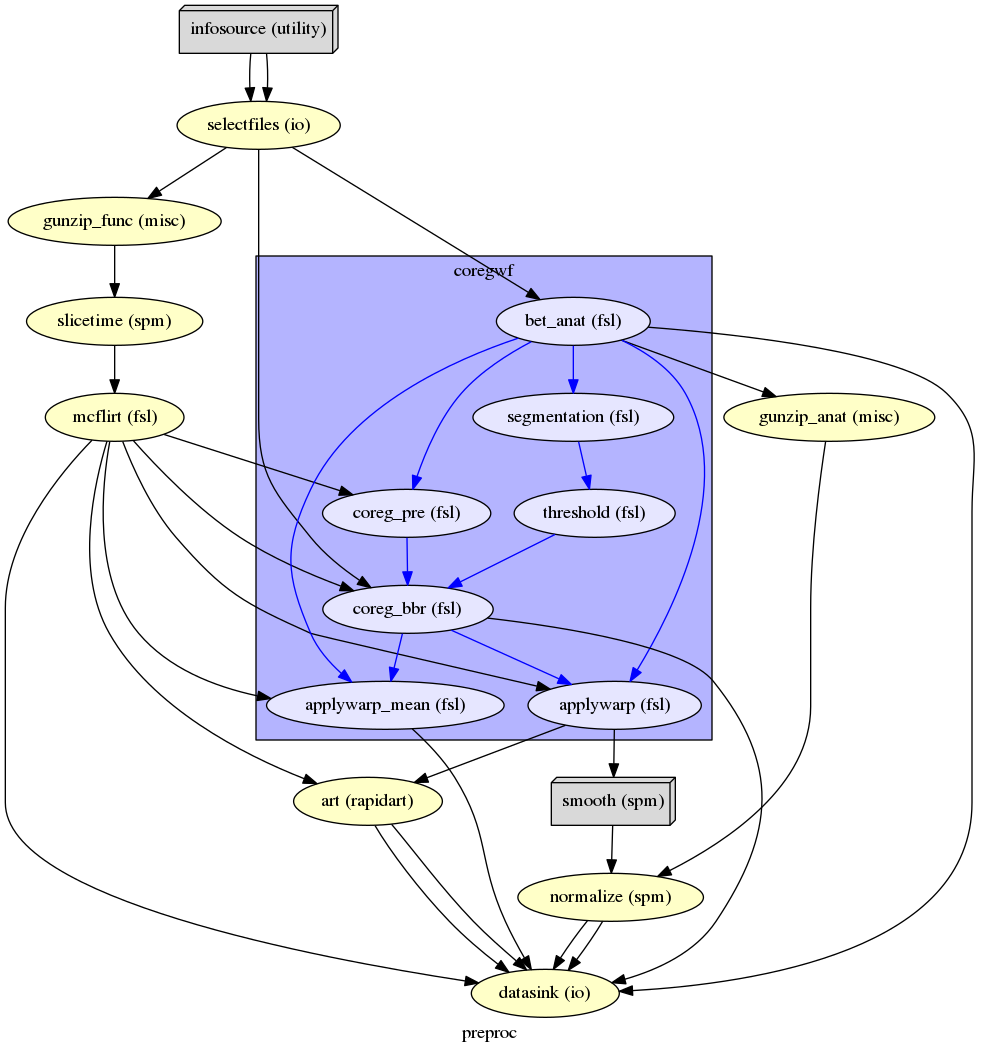

In [10]:
# Create preproc output graph# Creat # Create 
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

180910-14:48:15,99 nipype.workflow INFO:
	 Generated workflow graph: /home/zohyos7/wellbeing_experiment/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


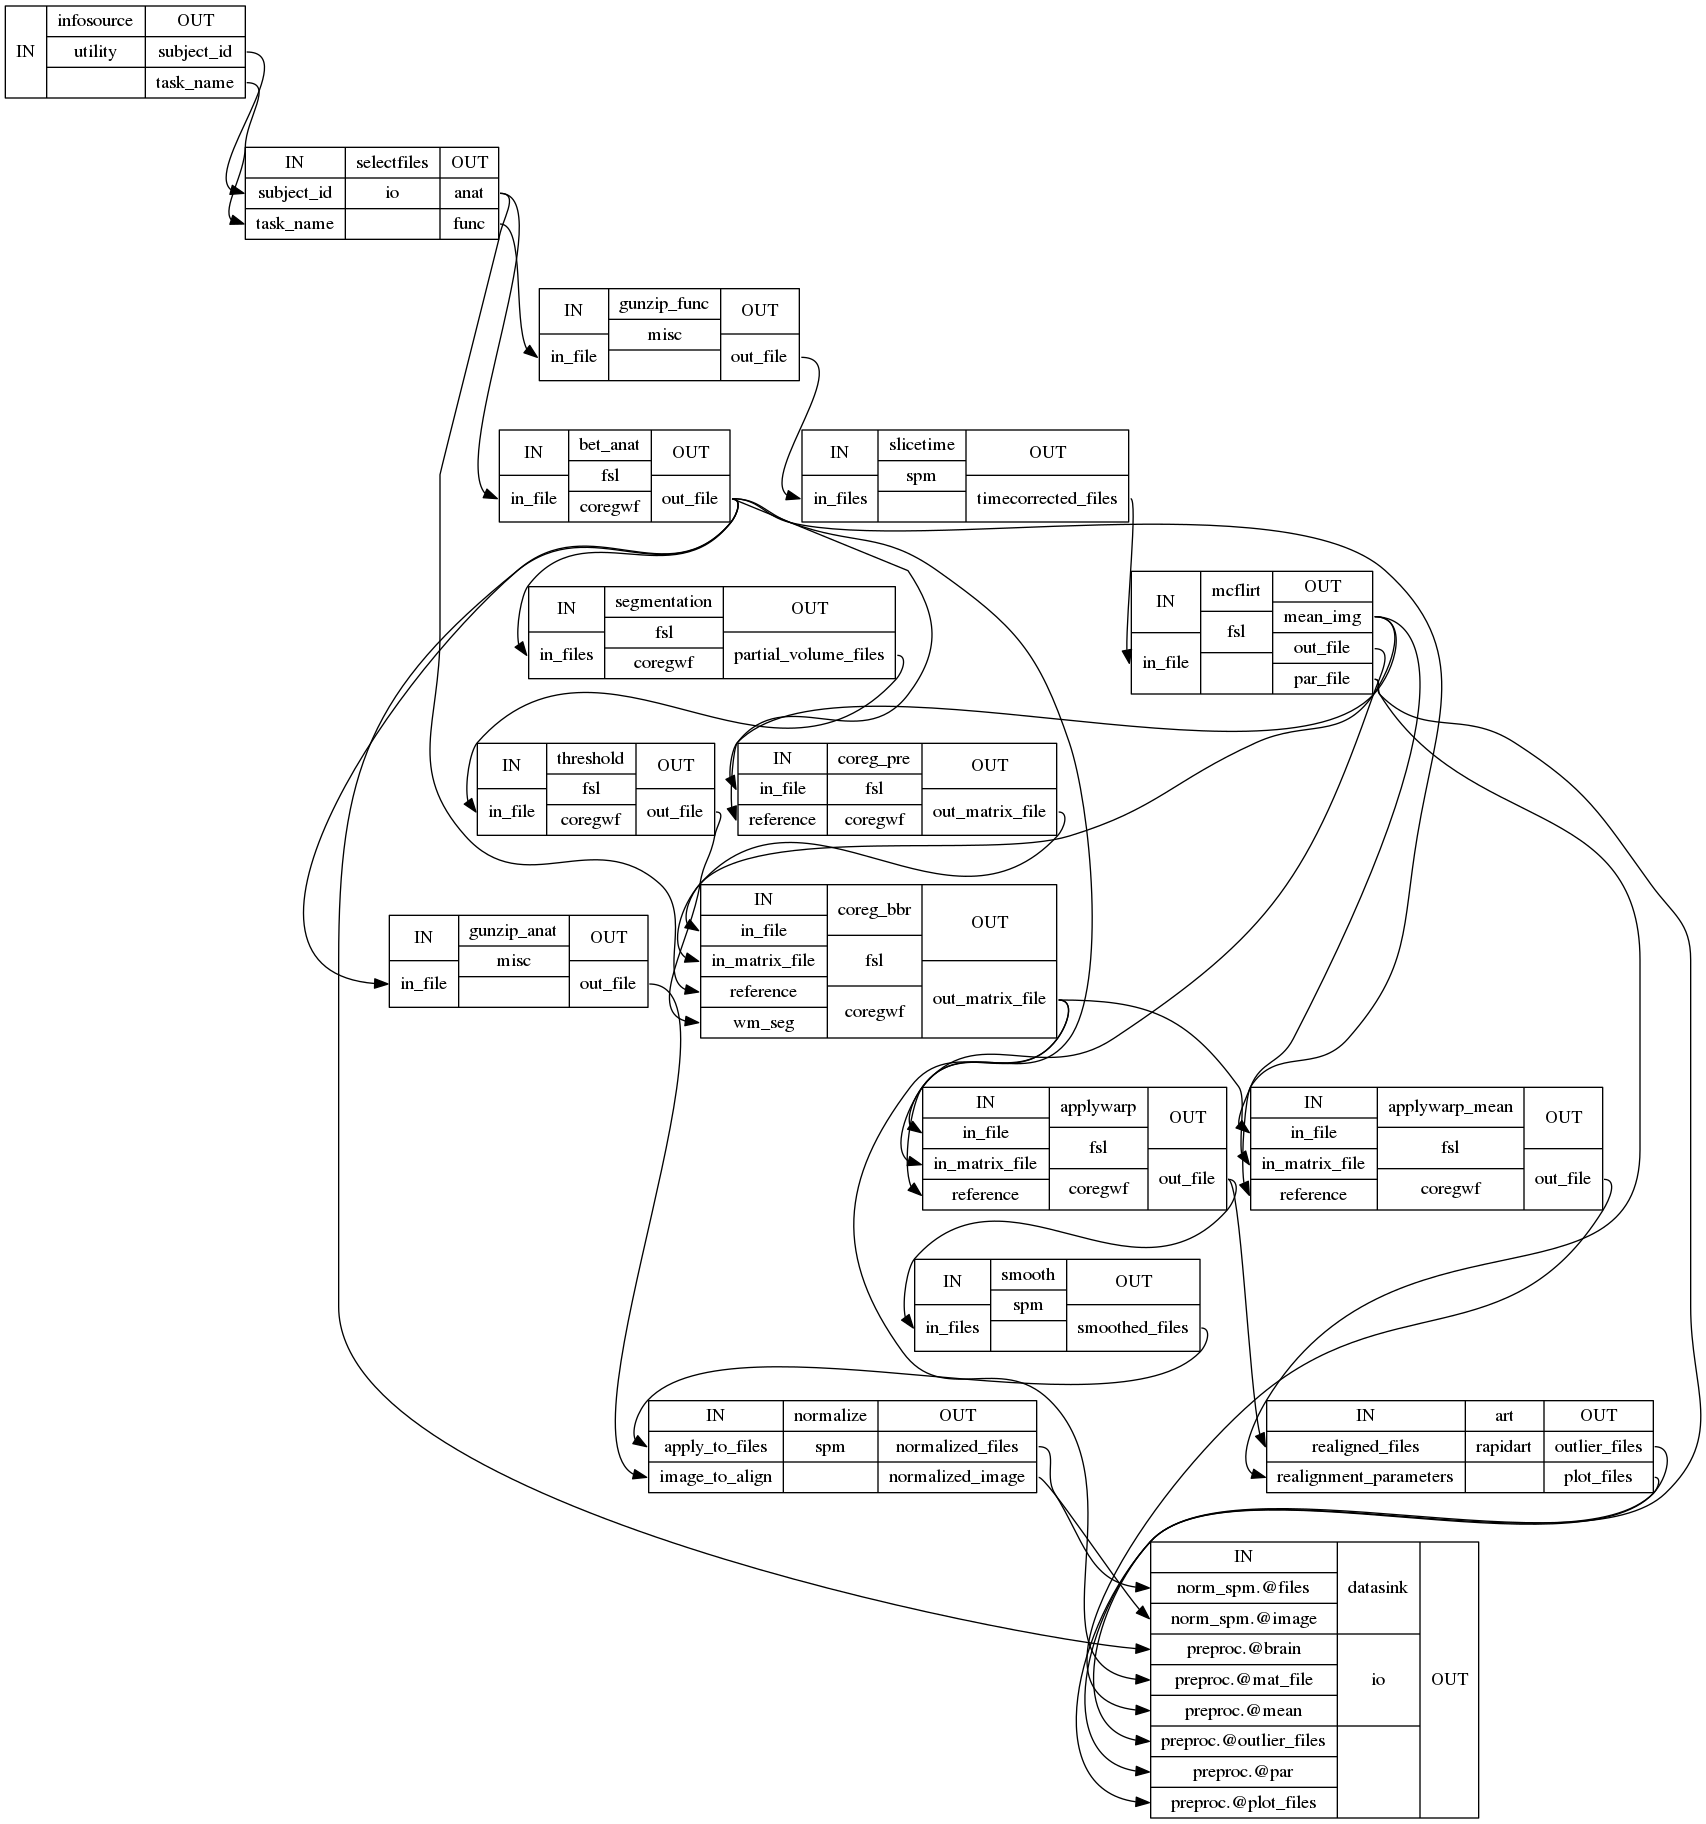

In [11]:
# Visualize the detailed graph# Visua # Visual 
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [12]:
preproc.run('MultiProc', plugin_args={'n_procs': 5})

180910-14:48:31,710 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
180910-14:48:31,792 nipype.workflow INFO:
	 Running in parallel.
180910-14:48:31,798 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 5/5.
180910-14:48:31,891 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/zohyos7/wellbeing_experiment/workingdir/preproc/_subject_id_2651_task_name_empathy/selectfiles".
180910-14:48:31,902 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
180910-14:48:31,912 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
180910-14:48:31,894 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/zohyos7/wellbeing_experiment/workingdir/preproc/_subject_id_3060_task_name_empathy/selectfiles".180910-14:48:31,896 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/zo

In [14]:
from nilearn.plotting import plot_stat_map
%matplotlib inline

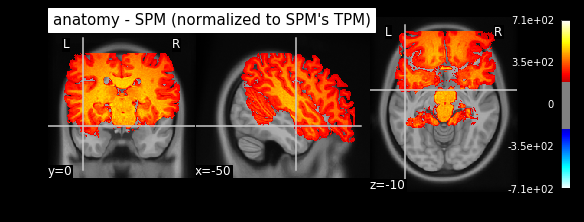

In [17]:
plot_stat_map(
    '/home/zohyos7/wellbeing_experiment/datasink/norm_spm/sub-2651/task-empathy/fwhm-4_wsub-2651_T1w_brain.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz',
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

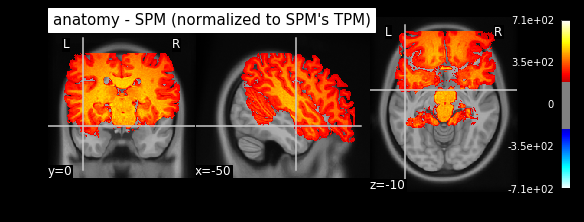

In [18]:
plot_stat_map(
    '/home/zohyos7/wellbeing_experiment/datasink/norm_spm/sub-2651/task-empathy/fwhm-4_wsub-2651_T1w_brain.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz',
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

In [2]:
from fmriprep.workflows.bold import init_bold_mni_trans_wf
wf = init_bold_mni_trans_wf(
    template='MNI152NLin2009cAsym',
    mem_gb=1,
    omp_nthreads=1,
    template_out_grid='native')

Failed to import duecredit due to No module named 'duecredit'
/home/zohyos7/anaconda3/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)
Downloaded 162303251 of 162303251 bytes (100.0%,    0.0s remaining) ...done. (19 seconds, 0 min)
